In [1]:
from fastai.vision.all import *
import cv2
import skimage as sm
import skimage.io
import tifffile
path = Path('/notebooks/DL_paper') # replace with your own path

In [4]:
# Training

# loads txt file with names of files in validation dataset
valid_fnames = (path/'models/div3Model/validDiv.txt').read_text().split('\n')

# Names of class
codes = np.loadtxt(path/'models/div3Model/codesDiv.txt', dtype=str)

# function to get mask using name of image
get_msk = lambda o: path/f'dat_division/divisionData3/train_masks'/f'{o.stem}_mask{o.suffix}'

# Make the dataloader 
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FileSplitter(path/'models/div3Model/validDiv.txt'),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(), # augmentations
                               Normalize.from_stats(*imagenet_stats)])

dls = camvid.dataloaders(path/f'dat_division/divisionData3/train_images', bs=8)
dls.vocab = codes
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

# define metric to assess model performance 
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean() 
opt = ranger

# Makes the unet model from a resnet34 model
learn = unet_learner(dls, resnet34, metrics=acc_camvid, self_attention=True, act_cls=Mish, opt_func=opt).to_fp16()

# Load training model if one avalable 
# learn.load(f'UNetCellDivision3')


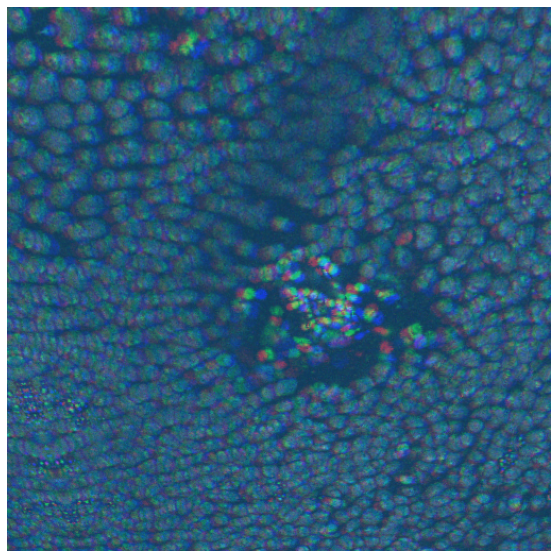

In [3]:
# displays image and overlays mask after augmentations have been applied
dls.show_batch(max_n=1, figsize=(14,10))

SuggestedLRs(valley=tensor(2.5119e-05))

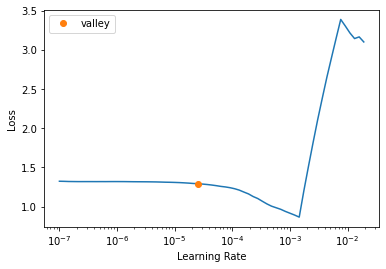

In [6]:
# Find learning rate
learn.lr_find()

epoch,train_loss,valid_loss,acc_camvid,time
0,0.151909,0.025542,0.996699,03:59


epoch,train_loss,valid_loss,acc_camvid,time
0,0.013245,0.011873,0.996913,05:12
1,0.008997,0.010460,0.997118,05:07


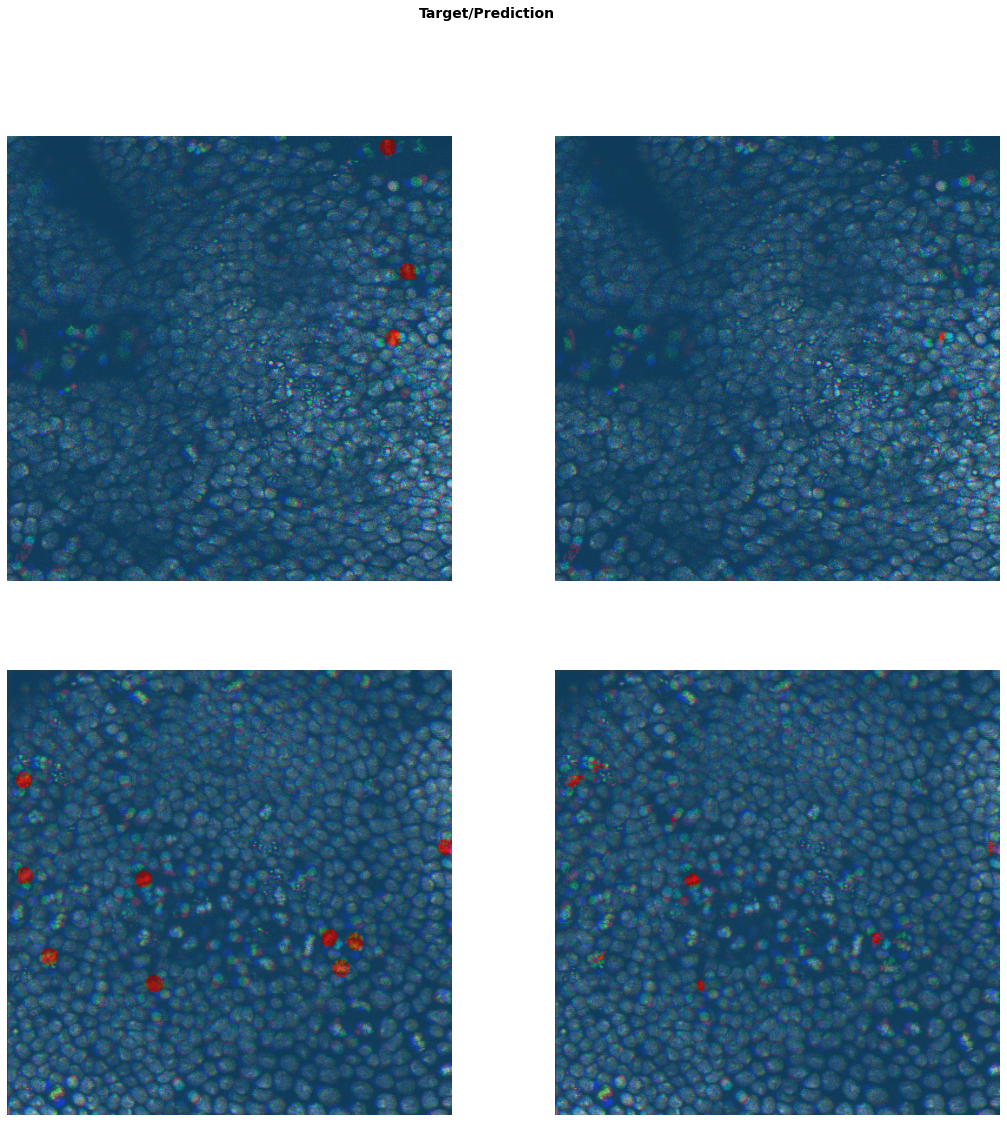

In [4]:
# Train model 
learn.fine_tune(2, base_lr=1e-4)
learn.save(f'UNetCellDivision3_1')
# Shows the ground truth with the model prediciton
learn.show_results(max_n=2, figsize=(18,18))

SuggestedLRs(valley=tensor(4.3652e-05))

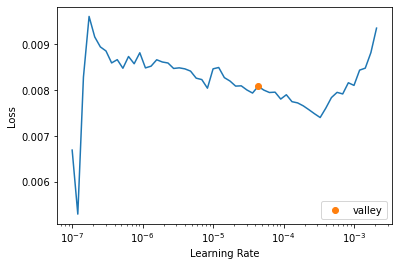

In [7]:
learn.unfreeze()
learn.lr_find()

In [8]:
learn.fine_tune(1, base_lr=1e-5)
learn.save(f'UNetCellDivision3_1')

epoch,train_loss,valid_loss,acc_camvid,time
0,0.007212,0.008605,0.997354,03:44


epoch,train_loss,valid_loss,acc_camvid,time
0,0.006838,0.008791,0.997348,03:49


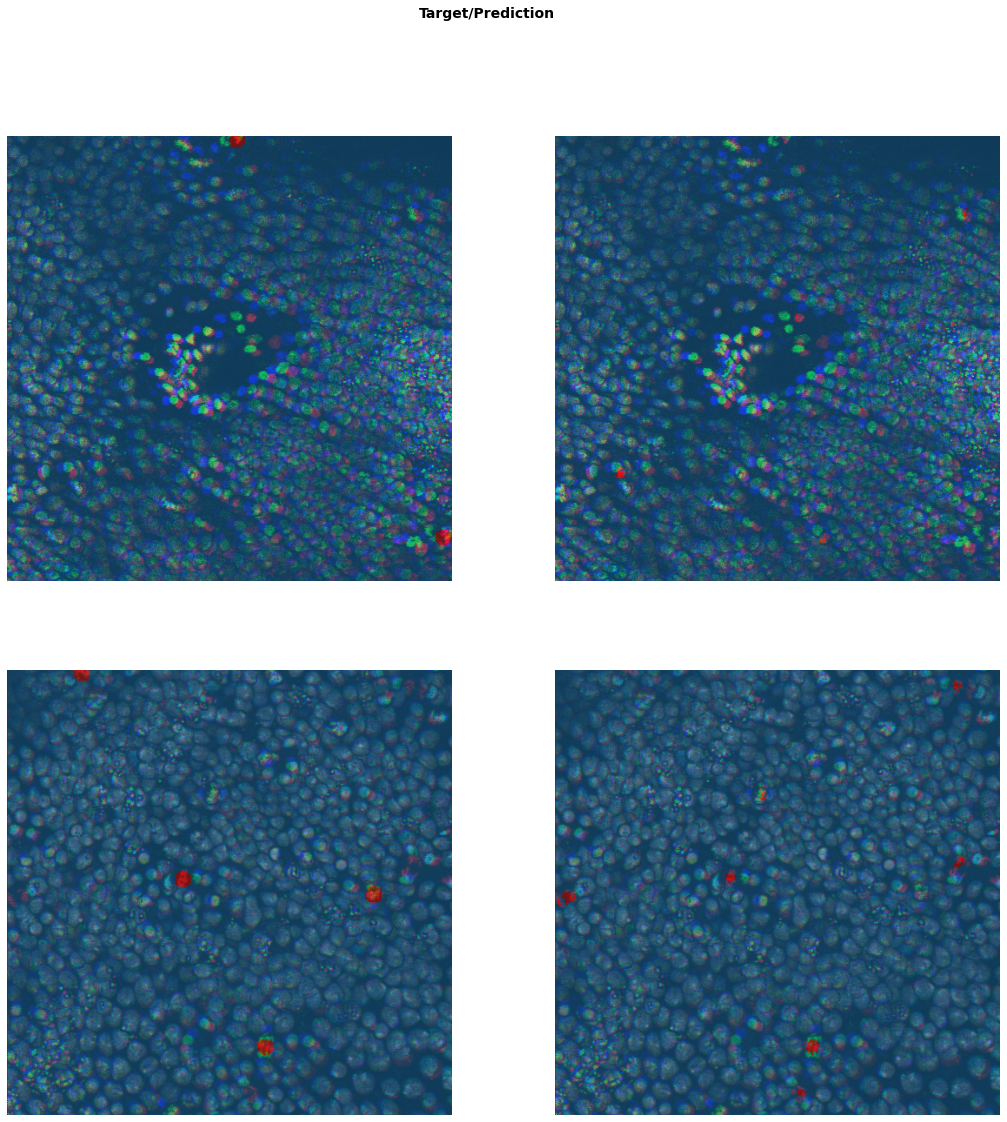

In [10]:
learn.show_results(max_n=2, figsize=(18,18))